# Data Exploration

Aim: load the data and explore it. The knowledge generated will guide the next data processing steps.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import spacy

## Data

The [dataset](https://www.kaggle.com/zynicide/wine-reviews) was uploaded on Kaggle by Zack Thout. It consists of 130’000 wine reviews scraped from the [WineEnthusiast](https://www.winemag.com/?s=&drink_type=wine) magazine website. I use a new version of the dataset, extracted on March 2019 (c.f. [discussion](https://www.kaggle.com/zynicide/wine-reviews/discussion/83970)) and found [here](https://www.kaggle.com/zynicide/wine-reviews/discussion/83970).  

In [9]:
raw_winedata = pd.read_csv("../data/winemag-data-190314.csv").drop("Unnamed: 0", axis=1) # indexes were stored as col
print(raw_winedata.shape)
raw_winedata.head()

(141617, 14)


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011.0
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0


In [10]:
# the columns and their types:
raw_winedata.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
vintage                  float64
dtype: object

### Missing Values

No descriptions are missing. That is good, because it is a priori the only column needed to build the unsupervised content-based recommendation system. However, some other columns have substantial amount of missing values. If we want to evaluate the recommendation system based on them, we might want to filter out some missing values first.

In [11]:
# missing values:
raw_winedata.isnull().sum()

country                     61
description                  0
designation              40182
points                       0
price                     9658
province                    61
region_1                 22886
region_2                 86832
taster_name              24917
taster_twitter_handle    30649
title                        0
variety                      1
winery                       0
vintage                   5234
dtype: int64

### Duplicates

No rows are full duplicates. However, 38 descriptions occur twice. Usually the descriptions occuring twice are two different wines coming from the same region. Sometimes even from the same winery, but with a different designation (e.g. "reserve").  

We cannot know if these duplicate descriptions are valid tasting description or copy-paste errors from the tasters. Thus, we could keep them and assume that the taster did voluntarily copy their description because the wine was indeed very similar.   

However we have to keep in mind that if two descriptions are exact copies, the similarity distance that we will compute, or tf-idf scores or topics, or actually any measure will be the same and that the second wine (duplicate) will be the top recommendation.  

In [12]:
# no duplicates of rows:
duplicates = raw_winedata[raw_winedata.duplicated()]
duplicates

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage


In [13]:
duplicates_description  = raw_winedata[raw_winedata.duplicated(subset='description', keep=False)].sort_values(by='description')
print('number of duplicated descriptions: ', duplicates_description.shape[0]/2)
duplicates_description[0:20]

number of duplicated descriptions:  38.0


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
68588,France,90–92. Barrel sample. This is a solid and dens...,Barrel Sample,91,NaN,Bordeaux,Margaux,NaN,Roger Voss,@vossroger,Château Pontac-Lynch 2012 Barrel Sample (Marg...,Bordeaux-style Red Blend,Château Pontac-Lynch,2012.0
68590,France,90–92. Barrel sample. This is a solid and dens...,Barrel Sample,91,NaN,Bordeaux,Moulis-en-Médoc,NaN,Roger Voss,@vossroger,Château Maucaillou 2012 Barrel Sample (Moulis...,Bordeaux-style Red Blend,Château Maucaillou,2012.0
98994,France,92–94. Barrel sample. With so much spicy fruit...,Barrel Sample,93,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château Gruaud Larose 2012 Barrel Sample (Sai...,Bordeaux-style Red Blend,Château Gruaud Larose,2012.0
98989,France,92–94. Barrel sample. With so much spicy fruit...,Barrel Sample,93,NaN,Bordeaux,Pauillac,NaN,Roger Voss,@vossroger,Château Grand-Puy-Lacoste 2012 Barrel Sample ...,Bordeaux-style Red Blend,Château Grand-Puy-Lacoste,2012.0
70421,Italy,"Almost too much of a good thing, Passo is a th...",Passo,88,35.0,Veneto,Rosso del Veronese,NaN,NaN,NaN,Stefano Accordini 2008 Passo Red (Rosso del Ve...,Red Blend,Stefano Accordini,2008.0
70436,Italy,"Almost too much of a good thing, Passo is a th...",Passo,88,35.0,Veneto,Rosso del Veronese,NaN,NaN,NaN,Stefano Accordini 2007 Passo Red (Rosso del Ve...,Red Blend,Stefano Accordini,2007.0
32875,Greece,"Aromas of citrus, melon and orange blossom sta...",NaN,88,15.0,Atalanti Valley,NaN,NaN,Susan Kostrzewa,@suskostrzewa,Hatzimichalis 2015 Chardonnay (Atalanti Valley),Chardonnay,Hatzimichalis,2015.0
115743,Greece,"Aromas of citrus, melon and orange blossom sta...",NaN,89,22.0,Cephalonia,NaN,NaN,Susan Kostrzewa,@suskostrzewa,Gentilini 2015 Robola (Cephalonia),Robola,Gentilini,2015.0
131889,Italy,"Aromas of fragrant white flower, wild herb and...",Oltre,89,30.0,Southern Italy,Greco di Tufo,NaN,Kerin O’Keefe,@kerinokeefe,Agricola Bellaria 2016 Oltre (Greco di Tufo),Greco,Agricola Bellaria,2016.0
137455,Italy,"Aromas of fragrant white flower, wild herb and...",Vento,89,21.0,Southern Italy,Campania,NaN,Kerin O’Keefe,@kerinokeefe,Capolino Perlingieri 2015 Vento Greco (Campania),Greco,Capolino Perlingieri,2015.0


/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


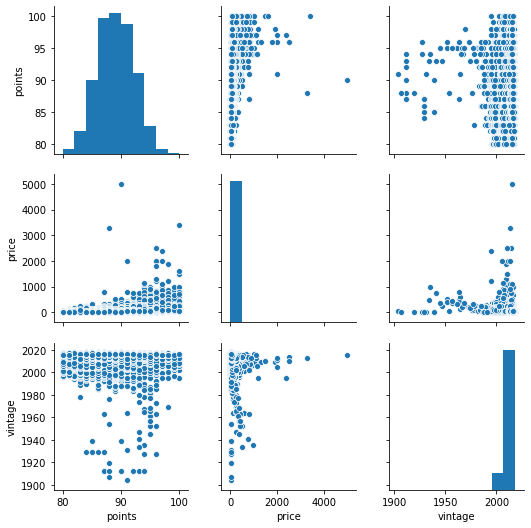

In [14]:
sns.pairplot(raw_winedata)

## The Descriptions

In [15]:
for i in range(1,20):
    print(raw_winedata.description[i], '\n')


This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016. 

Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented. 

Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish. 

Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew. 

Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this

### Bag of Words

Let's have a look at the most common words after removing the stopwords. By doing this, we will be able to judge if some of those recurring words are no useful taste descriptors and can be added to a domain-specific stopwords list.

In [16]:
parser = spacy.load('en_core_web_md')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: ', len(spacy_stopwords))
print('Stop words: ', list(spacy_stopwords))

Number of stop words:  326
Stop words:  ['because', 'them', 'as', 'eight', 'behind', "'s", 'yet', 'last', 'everything', 'how', 'somehow', 'anyhow', '’m', 'ourselves', 'hers', 'former', 'once', 'or', 'herein', 'since', 'thereby', 'can', 'elsewhere', 'full', 'six', 'were', 'back', "'d", 'nothing', 'only', 'within', 'next', 'first', 'however', 'with', 'thus', 'something', 'hereupon', 'each', 'due', 'amongst', 'beforehand', 'becoming', 'twenty', 'namely', 'thereafter', 'when', 'onto', 'toward', 'forty', 'we', 'whom', 'latterly', 'amount', 'call', 'nowhere', 'by', 'anyone', 'of', "'ll", 'every', 'this', 'what', 'whenever', 'whether', 'wherever', 'well', 'get', 'her', '‘s', 'anything', 'about', 'his', 'where', "'re", 'without', 'being', 'from', 'quite', '’ve', 'would', 'somewhere', 'same', 'nor', 'two', 'name', 'please', 'who', 'one', 'therefore', 'some', 'our', 'regarding', 'have', 'else', 'ca', 'its', 'their', 'themselves', 'mine', 'indeed', 'up', 'upon', 'whereas', 'was', 'often', '‘ve', 

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                        # minimum required occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=3000,             # max number of unique words
                            )

data_vectorized = vectorizer.fit_transform(raw_winedata['description'])

In [24]:
print(len(vectorizer.get_feature_names()), '\n')
print(vectorizer.get_feature_names())

3000 

['000', '100', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2040', 'ability', 'able', 'abound', 'abrasive', 'abrupt', 'absolutely', 'abundance', 'abundant', 'abv', 'acacia', 'accent', 'accented', 'accenting', 'accents', 'accentuate', 'accentuates', 'accessible', 'accompanied', 'accompanies', 'accompaniment', 'accompany', 'acid', 'acidic', 'acidity', 'acids', 'acre', 'acres', 'act', 'actually', 'add', 'added', 'adding', 'addition', 'additional', 'additions', 'adds', 'adequate', 'aeration', 'affordable', 'aftertaste', 'age', 'ageability', 'ageable', 'aged', 'ager', 'ages', 'ageworthy', 'aggressive', 'aging', 'aglianico', 'ago', 'ahead', 'aid', 'air', 'airing', 'airy', 'akin', 'albari', 'albeit', 'alcohol', 'alcoholic', 'alentejo', 'alexander', 'alicante', 'alive', 

In [21]:
print(data_vectorized.toarray().shape)

(141617, 3000)


In [30]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = vectorizer.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [33]:
get_top_n_words(raw_winedata['description'], 2000)

[('wine', 88822),
 ('flavors', 68104),
 ('fruit', 54225),
 ('palate', 45084),
 ('aromas', 45055),
 ('acidity', 39090),
 ('finish', 38132),
 ('tannins', 35255),
 ('drink', 34930),
 ('black', 32737),
 ('cherry', 32237),
 ('ripe', 30574),
 ('red', 24253),
 ('spice', 21223),
 ('notes', 20654),
 ('nose', 20166),
 ('oak', 19383),
 ('rich', 19284),
 ('fresh', 18996),
 ('berry', 18963),
 ('dry', 18143),
 ('plum', 16635),
 ('apple', 15162),
 ('fruits', 14888),
 ('white', 14585),
 ('soft', 14472),
 ('offers', 14298),
 ('light', 14253),
 ('blend', 14128),
 ('texture', 14034),
 ('blackberry', 13768),
 ('sweet', 13713),
 ('crisp', 13666),
 ('dark', 13604),
 ('bodied', 13356),
 ('citrus', 12873),
 ('bright', 12222),
 ('shows', 12119),
 ('vanilla', 11766),
 ('juicy', 11249),
 ('cabernet', 11245),
 ('lemon', 11240),
 ('pepper', 11233),
 ('green', 10533),
 ('fruity', 10422),
 ('raspberry', 10369),
 ('firm', 10253),
 ('good', 10065),
 ('balanced', 9594),
 ('peach', 9398),
 ('touch', 9321),
 ('dried', 92

There does not seem to be a lot of words that we should remove (i.e. as domain-specific stopwords) among those most common words. Excpet maybe the most common one: _wine_.  

We could also think if the fact that varieties are found in the description is good or not, e.g. _pinot_, _sauvignon_...

Else, this seems really promising!

## Decisions on Data Cleaning

* remove the wines without variety
* remove the duplicate descriptions, to stay on the safe side
* 
